--------------------APLICACIONES DE LA ANALÍTICA EN MARKETING: SISTEMA DE RECOMENDACIÓN PARA UNA PLATAFORMA ONLINE-----------------------

PROBLEMA DE NEGOCIO: 
Mejorar la experiencia de los clientes de una plataforma online que permita su fidelización en dicha plataforma, además, de lograr ser recomendada a nuevos clientes. 

PROBLEMA ANALÍTICO:
Realizar un sistema de recomendación de películas para los usuarios de la plataforma online. 

DISEÑO DE LA SOLUCIÓN: 
*se adjunta la imágen del diseño de la solución en la carpeta del github*

IMPORTAR PAQUETES

In [219]:
#Importar paquetes
import pandas as pd
import numpy as np
import sqlite3 as sql
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from ipywidgets import interact
import os 

In [220]:
#conectamos al local donde se tienen las bases de datos.
os.getcwd()
os.chdir('C:\\Users\\anita\\OneDrive\\Escritorio\\Universidad\\2022-1\\Aplicación de la analítica\\Marketing\\AnaliticaIII-Marketing')

In [221]:
#Para ejecutar sql y conectarse a la base de datos.
conn=sql.connect('db_movies')
cur=conn.cursor() ###para funciones que ejecutan sql en base de datos

In [222]:
#Función
def ejecutar_sql (nombre_archivo, cur):
    sql_file=open(nombre_archivo)
    sql_as_string=sql_file.read()
    sql_file.close
    cur.executescript(sql_as_string)

------------------------------------COMPRENSIÓN, LIMPIEZA Y TRANSFORMACIONES INICIALES--------------------------------------------

In [223]:
#Cargar tablas
movies= pd.read_sql('select * from movies', conn)
ratings = pd.read_sql('select * from ratings', conn)

Tabla Movies

In [224]:
#Imprimir la tabla de movies para conocer sus variables y sus datos de manera inicial, también su dimensión.
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [225]:
#Información general de la BD: datos nulos y tipo de variables.
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Tabla Ratings

In [226]:
#Imprimir la tabla de ratings para conocer sus variables y sus datos de manera inicial, también su dimensión.
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [227]:
#Información general de la BD: datos nulos y tipo de variables.
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [228]:
#Modificar formato de timestamp a datetime
from datetime import datetime
ratings['timestamp']= ratings.apply(lambda x: datetime.fromtimestamp(x['timestamp']), axis=1)
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-31 04:45:03
1,1,3,4.0,2000-07-31 04:20:47
2,1,6,4.0,2000-07-31 04:37:04
3,1,47,5.0,2000-07-31 05:03:35
4,1,50,5.0,2000-07-31 04:48:51


Nueva base de datos

In [229]:
#Crear una nueva base de datos con la unión de las tablas de movies y ratings. 
movie_ratings = pd.merge(ratings,movies, how="left", right_on="movieId", left_on="movieId")
movie_ratings.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,2000-07-31 04:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,2000-07-31 04:20:47,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,2000-07-31 04:37:04,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,2000-07-31 05:03:35,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,2000-07-31 04:48:51,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [230]:
#Información general de la nueva base de datos para saber si existen datos nulos y el tipo de variables.
movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  int64         
 1   movieId    100836 non-null  int64         
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
 4   title      100836 non-null  object        
 5   genres     100836 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 5.4+ MB


In [231]:
#Verificar si hay datos duplicados 
movie_ratings.duplicated().sum()

0

In [232]:
#Crear base de datos con variables dummies relacionado al género de películas.
genres = movies.copy()
genres = genres.drop(columns=['movieId', 'title'])
genres['genres'] = genres['genres'].str.split('|')
genres_dummies = pd.get_dummies(pd.DataFrame(genres['genres'].tolist()).stack()).sum(level=0)
genres = pd.concat([genres, genres_dummies], axis=1).drop(columns=['genres'])
genres

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9738,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9739,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9740,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [233]:
#Concatenar la base de datos movies con la base de datos de los generos de peliculas (dummies), eliminado la columna inicial de generos.
movies2 = pd.concat([movies, genres], axis=1)
movies2 = movies2.drop(['genres'], axis=1)
movies2.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [234]:
#Concatenar bases de datos de movies con dummies y ratings.
movie_ratings1 = pd.merge(ratings,movies2, how="left", right_on="movieId", left_on="movieId")
movie_ratings1.head(3)

,userId,movieId,rating,timestamp,title,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,2000-07-31 04:45:03,Toy Story (1995),0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,4.0,2000-07-31 04:20:47,Grumpier Old Men (1995),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,6,4.0,2000-07-31 04:37:04,Heat (1995),0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [235]:
#Creamos un nuevo df con pd.melt para invertir las columnas en filas y así conocer información de los géneros de las películas.
#se usa más adelante en el análisis exploratorio.
movies3 = pd.melt(movies2, id_vars= ['movieId', 'title'])
movies3.sample(10)

,movieId,title,variable,value
143776,79553,Ip Man 2 (2010),Mystery,0
141338,7460,Coffee and Cigarettes (2003),Mystery,0
30715,2014,Freaky Friday (1977),Animation,0
56416,89945,BlinkyTM (2011),Comedy,0
23506,5685,Real Women Have Curves (2002),Adventure,0
46213,74075,Stan Helsing (2009),Children,0
112987,32179,Elevator to the Gallows (a.k.a. Frantic) (Asce...,Horror,0
194190,143458,The Great Hypnotist (2014),Western,0
187715,3502,My Life (1993),Western,0
96266,117466,In the Heart of the Sea (2015),Fantasy,0


In [236]:
#Conococer la cantidad de calificaciones por género de película.
movies3.groupby('variable')[['value']].sum().reset_index()

,variable,value
0,(no genres listed),34.0
1,Action,1828.0
2,Adventure,1263.0
3,Animation,611.0
4,Children,664.0
5,Comedy,3756.0
6,Crime,1199.0
7,Documentary,440.0
8,Drama,4361.0
9,Fantasy,779.0


---------------------------------------------------ANÁLISIS EXPLORATORIO------------------------------------------------------------------

In [237]:
#Importar paquetes
import plotly.graph_objs as go #Graficos
import plotly.express as px
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt ### gráficos

In [238]:
# Para un mayor entendimiento de los datos se decide plantear varias preguntas relacionadas a las películas y sus calificaciones.
# ¿Cuales fueron las películas más calificadas por los usuarios?

base = movie_ratings.groupby(['title'])[['rating']].count().sort_values('rating', ascending = False).reset_index().head(10)

# crear gráfica
fig = px.bar(base, x = 'title', y='rating',
             title= '<b>Películas más calificadas<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Películas',
    yaxis_title = 'Calificación',
    template = 'simple_white',
    title_x = 0.5)

In [239]:
# De la anterior gráfica, se puede observar que Forrest Gump fue la película con mayor cantidad de calificaciones (329 votos), seguida de 
# Shawshank Redemption y Pulp Fiction con 317 y 307 votos respectivamente.

In [240]:
# ¿Cuales fueron las películas menos calificadas por los usuarios?
base = movie_ratings.groupby(['title'])[['rating']].count().sort_values('rating', ascending = True).reset_index().head(10)

# crear gráfica
fig = px.bar(base, x = 'title', y='rating',
             title= '<b>Películas menos calificadas<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Películas',
    yaxis_title = 'Calificación',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

In [241]:
# De la anterior gráfica, se puede observar que las películas con menores votaciones fueron ´71, Latter Days y Late Shift con 1 voto y/o 
# calificación cada una. 

In [242]:
# ¿Cúal es el top 5 de los géneros de peliculas?
base = movies3.groupby(['variable'])[['value']].sum().sort_values('value', ascending = False).reset_index().head(5)

# crear gráfica
fig = px.pie(base, values = 'value', names ='variable',
             title= '<b>Top 5 géneros de películas<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# agregar detalles a la gráfica
fig.update_layout(
    template = 'simple_white',
    title_x = 0.5)

fig.show()

In [243]:
# De la anterior gráfica, se puede observar que los 5 géneros que tuvieron mayor calificación fueron Drama con un 32,5%, seguido de 
# Comedia con 28% y Suspenso con 14,1%. El top 5 lo cierra Acción y Romance con 13,6% y 11,9% respectivamente.

In [244]:
# ¿Cúal es el bottom 5 de los géneros de peliculas menos calificados por los usuarios?
base = movies3.groupby(['variable'])[['value']].sum().sort_values('value', ascending = True).reset_index().head(5)

# crear gráfica
fig = px.pie(base, values = 'value', names ='variable',
             title= '<b>Bottom 5 géneros de películas<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# agregar detalles a la gráfica
fig.update_layout(
    template = 'simple_white',
    title_x = 0.5)

fig.show()

In [245]:
# De la anterior gráfica, se puede analizar que en el bottom de los géneros estan los musicales con 42,8%, seguido de las películas del oeste
# con un 21,4% e IMAX con un 20,3%.

In [246]:
# ¿Cúal es la calificación más recurrente y menos recurrente por parte de los usuarios?
base = ratings.groupby(['rating'])[['userId']].count().sort_values('userId', ascending = False).reset_index().head(10)

# crear gráfica
fig = px.bar(base, x = 'rating', y='userId',
             title= '<b>Conteo de calificaciones<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Rating',
    yaxis_title = 'Count',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

In [247]:
# Del anterior diagrama de barras, se puede observar que la calificación más recurrente es '4' con 26.818 votos, seguida de '3' con 20.047 votos
# y '5' con 13.211 votos. En cuanto a las menos recurrentes o con menores cantidad de votos se encuentra '0,5' con 1.370 votos, seguida de '1,5'
# con 1.791 votos y '2,5' con 5.550 votos.

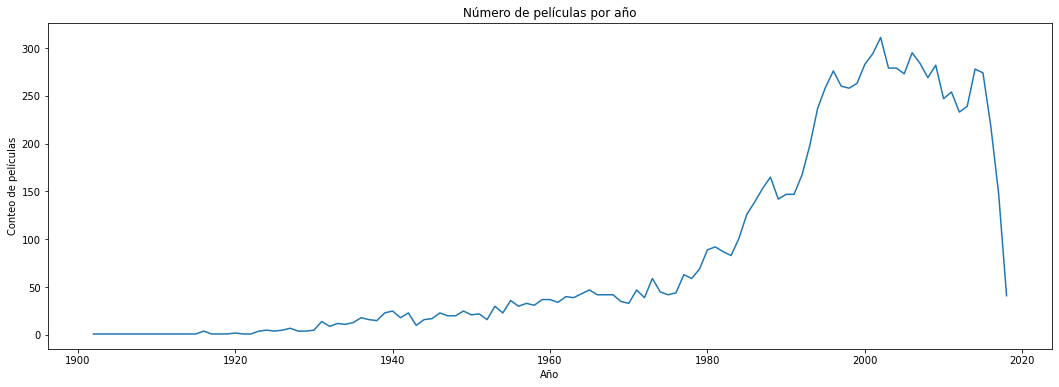

In [248]:
#¿Cúal ha sido el comportamiento del número de películas por año a medida que pasa el tiempo? y ¿cúal es el año con mayor número de películas?
#Para responder estas preguntas, se debe extraer el año de la columna 'title' de la tabla de movies.
movies = movies.copy()
movies['year'] = movies['title'].str.extract('\((\d{4})\)',expand = False)
movies = movies.dropna(axis=0)
movies['year'] = movies['year'].astype('int64')
movies['title'] = movies['title'].str.extract('(.*?)\s*\(', expand=False)
#crear gráfica.
movie_year = pd.DataFrame(movies['title'].groupby(movies['year']).count())
movie_year.reset_index(inplace=True)
movie_year.plot(x='year', y='title', legend=False, xlabel="Año", ylabel="Conteo de películas", title= 'Número de películas por año', figsize=(18, 6));

In [249]:
# De la anterior gráfica, se pueda observar un crecimiento a medida que pasa el tiempo de la cantidad de películas por año, especialmente
# desde 1960. Además, se observan picos muy notorios desde el año 2000 en adelante con más de 250 películas por año y de lo cual se puede
# deducir que el mundo cinematográfico tuvo un auge muy importante. También se observa un decrecimiento en la cantidad de películas por año 
# aproximadamente desde el 2015.

In [250]:
#¿Cúal ha sido el comportamiento de las calificaciones por parte de los usuarios por año, mes, día del mes y día de la semana?
#para responder estas preguntas extraemos de la fecha en columnas diferentes el año, el mes, el día del mes y el día de la semana.
movie_ratings['Year'] = movie_ratings['timestamp'].dt.year 
movie_ratings['Month'] = movie_ratings['timestamp'].dt.month
movie_ratings['Day'] = movie_ratings['timestamp'].dt.day 
movie_ratings['Dayweek'] = movie_ratings['timestamp'].dt.day_name()

base = movie_ratings.groupby(['Year'])[['rating']].count().sort_values('rating', ascending = False).reset_index()

# crear gráfica
fig = px.bar(base, x = 'Year', y='rating',
             title= '<b>Calificaciones por año<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Año',
    yaxis_title = 'Rating',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

In [251]:
# En cuanto a los ratings de las películas según los usuarios, se puede observar en la anterior gráfica que en el año 2000 se obtuvo la
# mayor cantidad de votos con 10.061 votos, seguido del 2017 con 8.203 votos y el 2007 con 7.111 votos. En cuanto a los años con menor
# cantidad de votos se encuentra 1998, 2014 y 2011 con 507, 1.439 y 1.690 votos respectivamente. No se observa ningún patrón y/o tendencia.

In [252]:
base = movie_ratings.groupby(['Month'])[['rating']].count().sort_values('rating', ascending = False).reset_index()

# crear gráfica
fig = px.bar(base, x = 'Month', y='rating',
             title= '<b>Calificaciones por mes<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Mes',
    yaxis_title = 'Rating',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

In [253]:
# En cuanto a las calificaciones por año, se puede observar que el mes con mayor número de calificaciones fue mayo con 10.875 votos, seguido
# de noviembre y agosto con 9.709 y 9.083 votos respectivamente. Los meses con menores calificaciones fue julio y octubre con 6.871 y 6.875
# votos respectivamente. 

In [254]:
base = movie_ratings.groupby(['Day'])[['rating']].count().sort_values('rating', ascending = False).reset_index()

# crear gráfica
fig = px.bar(base, x = 'Day', y='rating',
             title= '<b>Calificaciones por día del mes<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Día mes',
    yaxis_title = 'Rating',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

In [255]:
# En cuanto a las calificaciones por día del mes, el día 22 es el que tiene mayores calificaicones con 4.352 votos seguido del día 26 y del día 14
# con 4.279 y 4.180 votos respectivamente. El día con menor número de calificaciones es el 31 con 1.737 votos, cabe resaltar que esto puede ser
# debido a que no todos los meses cuentan con 31 días.

In [256]:
base = movie_ratings.groupby(['Dayweek'])[['rating']].count().sort_values('rating', ascending = False).reset_index()

# crear gráfica
fig = px.bar(base, x = 'Dayweek', y='rating',
             title= '<b>Calificaciones por día de la semana<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Día semana',
    yaxis_title = 'Rating',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

In [257]:
#En cuanto a las calificaciones por día de la semana, el domingo cuenta con mayor número de calificaciones con 17.735 votos y el día con menor 
#número de calificaciones es el jueves con 10.891 votos. Es algo lógico que el domingo sea el día de la semana con mayor número de calificaciones
#debido a que los domingos la gente descansa.

------------------------------------------------SISTEMAS DE RECOMENDACIÓN------------------------------------------------------------

Para el sistema de recomendación de películas para los usarios de la plataforma online, se deciden realizar 3 sistemas de recomendación:
1. Sistema de recomendación colaborativo por elemento.
2. Sistema de recomendación basado en filtro colaborativo.
3. Sistema de recomendación basado en contenido con base en lo visto por el usuario.

1. SISTEMA DE RECOMENDACIÓN COLABORATIVO POR ELEMENTO.

In [258]:
#Crear dataset con una matriz de las calificaciones que los userId le dan a las películas (movieId)
#Además, conocer la dimensión de ésta.
data1 = movie_ratings.pivot(index='movieId',columns='userId',values='rating')
data1 = data1.fillna(0)
data1

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [259]:
#saber cuantas calificaciones tiene cada pelicula y cuantas veces el usuario ha calificado.
usuariovotos = movie_ratings.groupby('movieId')['rating'].agg('count')
peliculavotos = movie_ratings.groupby('userId')['rating'].agg('count')

#¿Cúal es el maximo y mínimo de calificaciones de una película?
print(usuariovotos.max())
print(usuariovotos.min())

329
1


In [260]:
#¿Cúal es el maximo y minimo de calificaciones por parte de los usuarios?
print(peliculavotos.max())
print(peliculavotos.min())

2698
20


<AxesSubplot:title={'center':'Ratings por usuario'}, ylabel='Ratings'>

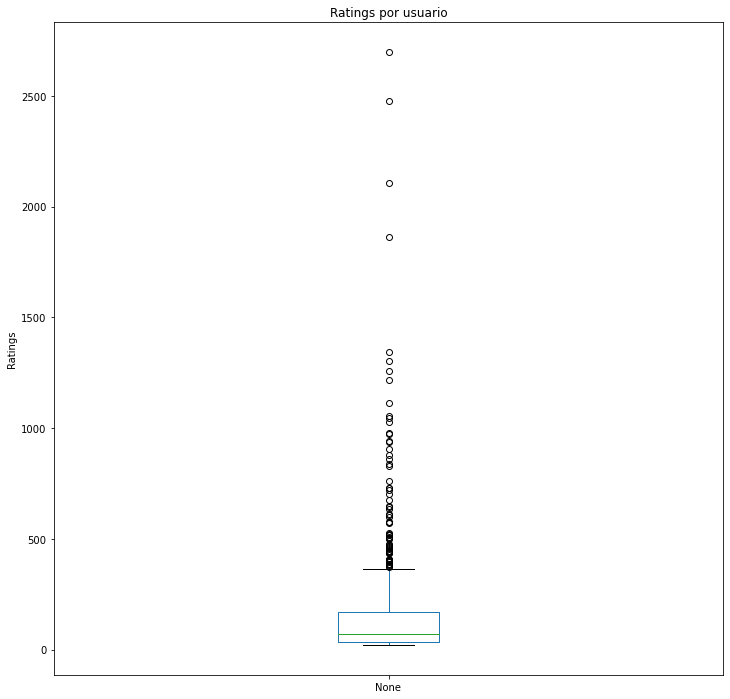

In [261]:
#Crear boxplot con ratings por usuarios
ratepelixusuario = ratings.groupby("userId").size().sort_values(ascending=False)
ratepelixusuario .plot.box(figsize=(12,12), ylabel="Ratings", title='Ratings por usuario')

In [262]:
#Del anterior boxplot, se puede deducir que las calificaciones por usuario están mas o menos entre 50 y 100, 
#por lo cual se tiene en cuenta lo siguiente:
#Construir un dataset con los requisitos de votacion de los usuarios mayor a 10 y calificación de peliculas mayor a 100 votos.
#Esto se hace con el objetivo de evitar el ruido y reducir el dataset.
data1 = data1.loc[usuariovotos[usuariovotos > 10].index,:]
data1=data1.loc[:,peliculavotos[peliculavotos > 100].index]
data1

userId,1,4,6,7,10,15,17,18,19,20,...,599,600,601,602,603,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,2.5,4.5,3.5,4.0,0.0,...,3.0,2.5,4.0,0.0,4.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,...,2.5,4.0,0.0,4.0,0.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,4.5,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.5,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [263]:
#Al ser una matriz densa, se usa la función csr_matrix para volvera dispera y así reducir el espacio que ésta consume en memoria
csr_data = csr_matrix(data1.values)
data1.reset_index(inplace=True)

In [264]:
#Se continúa con la selección del modelo, para este caso se decide trabajar con NearestNeighbors por diferentes razones.
#1. El algoritmo KNN es uno de los algoritmos de clasificación más simples, que puede dar resultados altamente competitivos.
#2. Al pertenecer al dominio de aprendizaje supervisado, se puede usar para reconocer patrones y extracción de datos.
#3. Dicho clasificador se usa como base o punto de referencia para otros clasificadores más complejos como las redes neuronales artificiales.
#4. Entre sus ventajas también está en que no hace suposiciones explicitas sobre la forma funcional de los datos, evitando los peligros de la 
#    distribución subyacente de los datos.
#5. Y por último, su facilidad de comprensión e interpretación.

#Se usa con metrica de coseno porque permite calcular la distancia y computacionalmente es más rapida.
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [294]:
#Función de recomendaciones, para este caso se decidió hacer una recomendación de 10 películas como se muestra a continuación:
def get_movie_recommendation(Movie_id = list(movies['title'])):
    n_movies_to_reccomend = 10
    
    if len(Movie_id):
        Movie_id=movies[movies['title'].str.contains(Movie_id)]        
        movie_idx= Movie_id.iloc[0]['movieId']
        movie_idx = data1[data1['movieId'] == movie_idx].index[0]
        
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),\
                               key=lambda x: x[1])[:0:-1]
        
        recommend_frame = []
        
        for val in rec_movie_indices:
            movie_idx = data1.iloc[val[0]]['movieId']
            idx =movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df.sort_values(by=['Distance'])
    
    else:
        
        return "No movies found. Please check your input"

In [295]:
#Obtener recomendaciones de películas con respecto al nombre ingresado
get_movie_recommendation('Spider-Man')

,Title,Distance
10,Spider-Man 2,0.232026
9,"Lord of the Rings: The Fellowship of the Ring,...",0.243543
8,"Lord of the Rings: The Two Towers, The",0.255674
7,Minority Report,0.256223
6,Star Wars: Episode II - Attack of the Clones,0.260246
5,X-Men,0.271716
4,"Bourne Identity, The",0.273384
3,"Lord of the Rings: The Return of the King, The",0.275932
2,Shrek,0.282840
1,Pirates of the Caribbean: The Curse of the Bla...,0.285845


In [296]:
#Se realiza un sistema de recomendación interactivo, para que se pueda elegir la película y este arroje la recomendación dependiendo
#de la película seleccionada.
print(interact(get_movie_recommendation))

interactive(children=(Dropdown(description='Movie_id', options=('Toy Story', 'Jumanji', 'Grumpier Old Men', 'W…

<function get_movie_recommendation at 0x000001ECF3FBE700>


2. SISTEMA DE RECOMENDACIÓN BASADO EN FILTRADO COLABORATIVO.

In [268]:
#Preguntar al usuario cúal es su usuario ID para recomendar películas con respecto a las películas ya vista por él
print('¿Cúal es tu ID?')
a = int(input())
if a in ratings.userId:
    print('Tu usuario ID es:',a )
else: 
    print("El usuario ID que ingresaste no existe, por favor ingresa otro usuario ID")

¿Cúal es tu ID?
Tu usuario ID es: 4


In [269]:
#En este caso se va a implementar el modelo de recomendación tomando en cuenta un solo usuario (userID = 4
#Se implementará la función de correlación de Pearson
#Base de datos de ratings sin variable timestamp
newrate = ratings.drop('timestamp',1)
#Se elimino el userId 4 para que no se comparara con el mismo más adelante
newrate = newrate[newrate.userId != a]
newrate

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [270]:
#Ejemplo para el sistema de recomendación con variable de entraba las películas que vio el usuario con Id 4 y su respectivo rate
InpMov = movie_ratings[(movie_ratings['userId']==a)]
#Organizar InpMov de manera que solo se pueda ver el movieId, title y rating de las películas vistas por el usuario con Id 4 
InpMov = InpMov[['movieId','title','rating']]
InpMov

,movieId,title,rating
300,21,Get Shorty (1995),3.0
301,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),2.0
302,45,To Die For (1995),3.0
303,47,Seven (a.k.a. Se7en) (1995),2.0
304,52,Mighty Aphrodite (1995),3.0
...,...,...,...
511,4765,L.I.E. (2001),5.0
512,4881,"Man Who Wasn't There, The (2001)",3.0
513,4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,4.0
514,4902,"Devil's Backbone, The (Espinazo del diablo, El...",4.0


In [271]:
#Filtrado de usuarios que han visto las mismas películas y han realizado alguna calificación en este caso del userId 4 
visto = newrate[newrate['movieId'].isin(InpMov['movieId'].tolist())]
visto = visto[visto.userId != a]
visto


,userId,movieId,rating
3,1,47,5.0
14,1,235,4.0
15,1,260,5.0
16,1,296,3.0
24,1,441,4.0
...,...,...,...
99819,610,4308,2.5
99840,610,4641,3.5
99861,610,4881,3.5
99865,610,4896,4.0


In [272]:
#Se va a implementar groupby para dividir las filas con respecto al userID
vistogroup = visto.groupby('userId')
#Se da como ejemplo la clasificación del userId 300
vistogroup.get_group(300)

,userId,movieId,rating
45500,300,593,4.0
45502,300,1704,3.0
45504,300,2324,5.0
45506,300,2571,4.0
45507,300,2762,3.5
45508,300,2858,5.0
45509,300,2959,4.5


In [273]:
#Se ordena para que los usuarios que hayan visto mas peliculas tengan prioridad 
#Esto con el objetivo de brindar una mejor recomendación.
vistogroup = sorted(vistogroup,  key=lambda x: len(x[1]), reverse=True)
#Se puede observar un usuario en específico
vistogroup[0:3]

[(474,
         userId  movieId  rating
  73101     474       21     4.0
  73110     474       32     4.0
  73117     474       45     4.0
  73119     474       47     4.0
  73121     474       52     4.0
  ...       ...      ...     ...
  74321     474     4641     4.0
  74359     474     4881     4.0
  74364     474     4896     4.5
  74365     474     4902     4.0
  74374     474     4967     3.5
  
  [158 rows x 3 columns]),
 (414,
         userId  movieId  rating
  62307     414       21     4.0
  62314     414       32     5.0
  62320     414       45     3.0
  62322     414       47     4.0
  62325     414       52     3.0
  ...       ...      ...     ...
  63770     414     4765     4.0
  63797     414     4881     5.0
  63803     414     4896     2.0
  63808     414     4902     4.0
  63823     414     4967     4.0
  
  [151 rows x 3 columns]),
 (603,
         userId  movieId  rating
  96104     603       21     5.0
  96109     603       32     3.0
  96113     603       45    

In [274]:
#Luego se hace la comparación de los usuarios con el usuario anteriormente seleccionado, con el objetivo de 
#encontrar una similitud de los usuarios, esto a través del coeficiente de correlación de pearson, ya que este no varía con la escala.

In [275]:
#Se elije un conjunto de usuarios para hacer las iteraciones.
vistogroup = vistogroup[0:100]

In [276]:
#Para calcular la correlación de pearson, que se almacenará en un diccionario.
from math import sqrt

#La correlación de Pearson = diccionario 
PearsonCorrelation = {}
for name, group in vistogroup:
    group = group.sort_values(by='movieId')
    InpMov = InpMov.sort_values(by='movieId')
#Sacar N
    n = len(group)
#Obtener puntajes de revisión
    temp = InpMov[InpMov['movieId'].isin(group['movieId'].tolist())]
    tempRate = temp['rating'].tolist()
    tempGroup = group['rating'].tolist()
  #Calcular la Correlación Pearson entre dos usuarios, x e y con respecto a la ecuación
    Sxx = sum([i**2 for i in tempRate]) - pow(sum(tempRate),2)/float(n)
    Syy = sum([i**2 for i in tempGroup]) - pow(sum(tempGroup),2)/float(n)
    Sxy = sum( i*j for i, j in zip(tempRate, tempGroup)) - sum(tempRate)*sum(tempGroup)/float(n)
    if Sxx != 0 and Syy != 0:
        PearsonCorrelation[name] = (Sxy/(sqrt((Sxx*Syy))))
    else:
        PearsonCorrelation[name] = 0
PearsonCorrelation.items()

dict_items([(474, 0.07299906208258314), (414, 0.12268762843817493), (603, 0.09009019233809007), (599, 0.08060613049558181), (182, -0.015972355026976012), (387, -0.0022317538419089514), (391, 0.27217873272411147), (606, 0.14460333529583172), (288, 0.006304712053587542), (68, 0.02259838791653024), (156, 0.09869305050179072), (480, 0.139714863938912), (275, 0.038865569689867444), (600, 0.12872243508723877), (64, 0.032384918026885506), (597, 0.20210005679478374), (91, 0.0994174687397108), (469, 0.11012425960198087), (57, 0.2526808677495574), (274, -0.056287790547596826), (448, 0.30875537950600646), (590, 0.38833389034321686), (307, 0.17200963724557627), (19, 0.07200043191433954), (177, 0.10804681252295656), (489, 0.038014756877553645), (608, -0.1705007383731049), (483, -0.06481942969096398), (221, 0.10197231792332478), (199, 0.3129824054733921), (132, -0.06101538305074521), (462, 0.404727251159506), (45, 0.060010408661818004), (135, 0.20133354754132093), (202, 0.3451748964197802), (453, -0

In [277]:
#lo anterior dio como resultado dos valores, el primero representa el ID del usuario y el segundo es el valor del coeficiente 
#Los valores más cercanos a 1 representan mayor similitud entre los gustos de dos usuarios
#Los valores más cercanos a -1 representan menor similitud entre los gustos de dos usuarios

In [278]:
#Calcular la correlación Pearson 
pearsonDF = pd.DataFrame.from_dict(PearsonCorrelation, orient='index')
#la variable index similar va a almacenar los valores de los coeficientes
pearsonDF.columns = ['Index Similar']
#Se clasifica el index por el userID
pearsonDF['userId'] = pearsonDF.index
#Se organiza con respecto a la longitud de pearsonDF
pearsonDF.index = range(len(pearsonDF))
pearsonDF.head()

,Index Similar,userId
0,0.072999,474
1,0.122688,414
2,0.090090,603
3,0.080606,599
4,-0.015972,182


In [279]:
#Se organizan los usuarios desde un mayor index_similar al menor, esto quiere decir que se muestran los usuarios con similares gustos primero
UsuariosTop=pearsonDF.sort_values(by='Index Similar', ascending=False)
UsuariosTop.head()

,Index Similar,userId
31,0.404727,462
21,0.388334,590
34,0.345175,202
44,0.320074,219
29,0.312982,199


In [280]:
#Va a mostrar los usuario con mayor similitud de gustos en este caso con el userID 4 y se va a unir con la base de datos newrate
UsuariosTopRate=UsuariosTop.merge(newrate, left_on='userId', right_on='userId', how='inner')
UsuariosTopRate.head()

,Index Similar,userId,movieId,rating
0,0.404727,462,1,1.5
1,0.404727,462,10,3.0
2,0.404727,462,16,3.5
3,0.404727,462,21,4.0
4,0.404727,462,25,3.0


In [281]:
#Se multiplica la similitud de los puntajes de los usuarios
UsuariosTopRate['Rating Peso'] = UsuariosTopRate['Index Similar']*UsuariosTopRate['rating']
UsuariosTopRate.head()

,Index Similar,userId,movieId,rating,Rating Peso
0,0.404727,462,1,1.5,0.607091
1,0.404727,462,10,3.0,1.214182
2,0.404727,462,16,3.5,1.416545
3,0.404727,462,21,4.0,1.618909
4,0.404727,462,25,3.0,1.214182


In [282]:
#Se aplica una multiplicación de rating y rating peso 
#Se suman los nuevos rates y estos son divididos por la suma rating peso después de agruparlos por movieID 
tempTopUsersRating = UsuariosTopRate.groupby('movieId').sum()[['Index Similar','Rating Peso']]
#Se escoge el nombre de las variables a mostrar
tempTopUsersRating.columns = ['Suma Index Similar','Suma Rating Peso']
tempTopUsersRating.head()


,Suma Index Similar,Suma Rating Peso
movieId,,
1,5.765932,22.632306
2,3.952222,12.428457
3,2.420205,8.146492
4,0.101553,0.111577
5,0.867546,1.409056


In [283]:
#Dataframe vacio para guardar la información
rec_df = pd.DataFrame()
#Se muestra con respecto el promedio ponderado
rec_df['Peso promedio de recomendación'] = tempTopUsersRating['Suma Rating Peso']/tempTopUsersRating['Suma Index Similar']
#El indice será representado por movieID 
rec_df['movieId'] = tempTopUsersRating.index
rec_df.head()


,Peso promedio de recomendación,movieId
movieId,,
1,3.925177,1
2,3.144676,2
3,3.366034,3
4,1.098699,4
5,1.624187,5


In [284]:
#Se organizan los valores de Peso promedio de recomendación mayor a menor 
rec_df = rec_df.sort_values(by='Peso promedio de recomendación', ascending=False)
rec_df.head(10)

,Peso promedio de recomendación,movieId
movieId,,
113348,602.688841,113348
6645,179.375820,6645
2880,134.705889,2880
725,69.412578,725
61160,55.094074,61160
2377,50.651091,2377
378,47.089420,378
1382,43.159864,1382
2315,35.483530,2315


In [285]:
#Se muestra las recomendaciones de películas en este caso para el usuario con ID 4 
recomendaciones = movies.loc[movies['movieId'].isin(rec_df.head(100)['movieId'].tolist())]
recomendaciones

,movieId,title,genres,year
17,18,Four Rooms,Comedy,1995
56,63,Don't Be a Menace to South Central While Drink...,Comedy|Crime,1996
222,258,"Kid in King Arthur's Court, A",Adventure|Children|Comedy|Fantasy|Romance,1995
240,278,Miami Rhapsody,Comedy,1995
285,327,Tank Girl,Action|Comedy|Sci-Fi,1995
...,...,...,...,...
8490,113348,Teenage Mutant Ninja Turtles,Action|Adventure|Comedy,2014
8890,134393,Trainwreck,Comedy|Romance,2015
8906,135143,Fantastic Beasts and Where to Find Them,Fantasy,2016
9023,140711,American Ultra,Action|Comedy|Sci-Fi|Thriller,2015


3. SISTEMA DE RECOMENDACIÓN BASADO EN CONTENIDO CON BASE EN LO VISTO POR EL USUARIO.

In [286]:
#Traemos de nuevo la tabla de movies.
movies2.head(5)

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [287]:
#De la base de datos movie_ratings se crea una base solo con las variables dummies de los generos.
generos = movie_ratings1.drop('movieId',1).drop('title',1).drop('(no genres listed)',1).drop('userId',1).drop('rating',1).drop('timestamp',1)
generos

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
100832,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
100833,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
100834,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [288]:
#Para aprender la preferencias recibidas, se pondera cada uno de los géneros. Esto se hace por la
#multiplicación de los ratings por lo géneros. A continuación extraemos la columan de ratings.
movie_ratings1['rating']

0         4.0
1         4.0
2         4.0
3         5.0
4         5.0
         ... 
100831    4.0
100832    5.0
100833    5.0
100834    5.0
100835    3.0
Name: rating, Length: 100836, dtype: float64

In [289]:
#multiplicación anteriormente mencionda, que nos da como resultado los pesos para cada preferencia del usuario.
#también se conoce como perfil del usuario.
usuario = generos.transpose().dot(movie_ratings1['rating'])
usuario

Action         105629.0
Adventure       84771.5
Animation       25366.0
Children        31426.5
Comedy         132183.5
Crime           61024.0
Documentary      4629.5
Drama          153296.5
Fantasy         41312.5
Film-Noir        3410.5
Horror          23755.5
IMAX            14998.0
Musical         14746.5
Mystery         27875.5
Romance         63552.0
Sci-Fi          59587.0
Thriller        92415.5
War             18504.5
Western          6917.0
dtype: float64

In [290]:
#Géneros de cada película al marco de datos original
tablaGeneros = movie_ratings1.set_index(movie_ratings1['movieId'])
#Se eliminan algunas columnas
tablaGeneros = tablaGeneros.drop('movieId', 1).drop('title', 1).drop('(no genres listed)', 1).drop('userId', 1).drop('rating', 1).drop('timestamp', 1)
tablaGeneros.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,
1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
47,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
50,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0


In [291]:
#Se lleva el peso promedio de cada película basado en el perfil de ingreso para luego recomendar
#las películas.
TablaRecomendaciones = ((tablaGeneros*usuario).sum(axis=1))/(usuario.sum())
TablaRecomendaciones.head()


movieId
1     0.326351
3     0.202750
6     0.268353
47    0.124602
50    0.187813
dtype: float64

In [292]:
#Ordena nuestra recomendación en orden descendente
TablaRecomendaciones = TablaRecomendaciones.sort_values(ascending=False)
#Valores
TablaRecomendaciones.head()


movieId
81132    0.716053
81132    0.716053
4719     0.656169
4719     0.656169
4719     0.656169
dtype: float64

In [293]:
#Tabla de recomendaciones final.
movies.loc[movies['movieId'].isin(TablaRecomendaciones.head(100).keys())]

,movieId,title,genres,year
19,20,Money Train,Action|Comedy|Crime|Drama|Thriller,1995
118,145,Bad Boys,Action|Comedy|Crime|Drama|Thriller,1995
400,459,"Getaway, The",Action|Adventure|Crime|Drama|Romance|Thriller,1994
1103,1432,Metro,Action|Comedy|Crime|Drama|Thriller,1997
3460,4719,Osmosis Jones,Action|Animation|Comedy|Crime|Drama|Romance|Th...,2001
3608,4956,"Stunt Man, The",Action|Adventure|Comedy|Drama|Romance|Thriller,1980
3657,5027,Another 48 Hrs.,Action|Comedy|Crime|Drama|Thriller,1990
3989,5628,Wasabi,Action|Comedy|Crime|Drama|Thriller,2001
4631,6902,Interstate 60,Adventure|Comedy|Drama|Fantasy|Mystery|Sci-Fi|...,2002
4693,7007,"Last Boy Scout, The",Action|Comedy|Crime|Drama|Thriller,1991


------------------------------------------------DESPLIEGUE DE LOS MODELOS------------------------------------------------------------

El despliegue es el que permite que los usuarios obtengan la información recolectada de los modelos creados por los científicos de datos, en este caso es representado por la lista de recomendaciones de películas, para determinar la manera en que se hará el despliegue se tomara en cuenta el almacenamiento de la base de datos sql, la cual se guardará localmente por ser una base de datos que no es de gran tamaño y no ocasionará un mayor gasto computacional. Además, el tipo de despliegue será en batch y se hará cada dos días como el entrenamiento del modelo que se realizará con la misma periodicidad. 



El proceso es el siguiente:


1. Se programa en el computador para que el modelo corra cada dos días los modelos a traves del programador de tareas. A la vez, este analice y actualice la nueva información dada por los usuarios, se logrará acceder a esta por la conexión que existe con las bases de datos de sql y se hará nuevamente el preprocesamiento de los datos.
2. Los resultados serán depositados en una tabla y exportados en un archivo de excel csv, el cúal su link de acceso se encontrará en línea y será actualizado tambien cada dos días.
3. El usuario que quiera obtener la lista de recomendaciones de películas podrá dirigirse a este link de acceso, filtrar por el ID de su usuario y obtener la lista de recomendaciones. 